In [139]:
import numpy as np
import torch as t
from torch import Tensor
import matplotlib.pyplot as plt
# now let us import jaxtyping
from jaxtyping import Float
import torch.optim as optim
from einops import rearrange, repeat, einsum

In [198]:
def cholesky_parametrization(params):
    # Extract the batch size and the number of rows/columns in the matrix
    batch_size, n_params = params.shape
    n = int((np.sqrt(1 + 8 * n_params) - 1) / 2)
    
    # Initialize the lower triangular matrix L with zeros
    L = t.zeros(batch_size, n, n, dtype=params.dtype, device=params.device)
    
    # Unpack the parameters into the lower triangular matrix L
    tril_indices = t.tril_indices(n, n)
    L[:, tril_indices[0], tril_indices[1]] = params
    
    # Ensure positive diagonal entries by taking the exponential of the diagonal
    L[:, range(n), range(n)] = t.exp(L[:, range(n), range(n)])
    
    # Compute the positive definite matrix A = L * L^T
    A = t.matmul(L, L.transpose(-2, -1))

    eps = 1e-6
    A += eps * t.eye(n, dtype=params.dtype, device=params.device)

    return A


def reverse_cholesky_parametrization(A):
    # Extract the batch size and the number of rows/columns in the matrix
    batch_size, n, _ = A.shape

    # see wether A is positive definite
    assert t.diagonal(A, dim1=-2, dim2=-1).min() > 0 
    assert t.allclose(A, A.transpose(-2, -1))


    # Compute the Cholesky decomposition of A
    L = t.cholesky(A)
    #reverting the exponential in the diagonal of L
    L[:, range(n), range(n)] = t.log(L[:, range(n), range(n)])
    
    # Extract the lower triangular part of L (including the diagonal)
    tril_indices = t.tril_indices(n, n)
    params = L[:, tril_indices[0], tril_indices[1]]
    
    # Flatten the parameters into a vector
    params = params.view(batch_size, -1)
    
    return params



class MultidimensionalGaussian:
    def __init__(self, n_features,n_dimensions,L_params = None):
        self.n_dimensions = n_dimensions
        self.n_features = n_features
        if L_params is None:
            self.L_params = t.randn(n_features, n_dimensions * (n_dimensions + 1) // 2)
        else:
            assert L_params.shape == (n_features, n_dimensions * (n_dimensions + 1) // 2)
            self.L_params = L_params
        self.transformation_matrix = cholesky_parametrization(self.L_params)
        self.eigenvalues, self.eigenvectors = np.linalg.eigh(self.transformation_matrix)
        #print(self.transformation_matrix.shape)

        self.destribution = t.distributions.MultivariateNormal(t.zeros(n_dimensions), self.transformation_matrix)

    def sample(self, num_samples):
        acts = t.exp(t.normal(0,1,(num_samples,self.n_features)))#t.ones((num_samples,self.n_features)) 
        #t.exp(t.normal(0,1,(num_samples,self.n_features)))
            #t.rand(num_samples,self.n_features))
        samples = self.destribution.sample((num_samples,))
        #print("samples shape", samples.shape)
        act_weighted_samples = t.einsum('n f d, n f -> n d', samples, acts)
        return acts, act_weighted_samples
# Example usage
n_features = 10
n_dimensions = 50
num_samples = 100

gaussian = MultidimensionalGaussian(n_features,n_dimensions)
acts, outputs = gaussian.sample(num_samples)
print("act shape", acts.shape)
print("output shape", outputs.shape)

act shape torch.Size([100, 10])
output shape torch.Size([100, 50])


In [199]:
n_features = 2
n_dimensions = 2
params = t.randn(n_features, n_dimensions * (n_dimensions + 1) // 2)
A = cholesky_parametrization(params)
#A[0,1,0] -= 1
params_reconstructed = reverse_cholesky_parametrization(A)

print("params shape", params.shape)
print("params_reconstructed shape", params_reconstructed.shape)
print("params", params)
print("params_reconstructed", params_reconstructed)


params shape torch.Size([2, 3])
params_reconstructed shape torch.Size([2, 3])
params tensor([[-0.0712,  1.1961,  1.3922],
        [-0.3648, -0.4525,  0.0806]])
params_reconstructed tensor([[-0.0712,  1.1961,  1.3922],
        [-0.3648, -0.4525,  0.0806]])


In [201]:
def NLL(cholesky_params, acts, noise):
    A = cholesky_parametrization(cholesky_params)
    activated_A = t.einsum('f x y, n f -> n x y', A, acts**2)
    
    # Calculate the log-determinant term
    nll_1 = 0.5 * t.log(t.det(activated_A))
    
    inv_activated_A = t.inverse(activated_A)
    assert noise.shape == inv_activated_A.shape[:-1]
    
    # Calculate the quadratic term
    nll_2 = 0.5 * t.sum(noise.unsqueeze(-1) * (inv_activated_A @ noise.unsqueeze(-1)), dim=(-2, -1))
    
    # Add the normalization term
    n_dimensions = A.shape[-1]
    nll_3 = 0.5 * n_dimensions * np.log(2 * t.pi)
    
    return t.mean(nll_1 + nll_2 + nll_3)

In [214]:
n_features = 10
n_dimensions = 5
right_L = t.randn(n_features, n_dimensions * (n_dimensions + 1) // 2)

gaussian = MultidimensionalGaussian(n_features, n_dimensions, right_L)
L_learned = t.randn(n_features, n_dimensions * (n_dimensions + 1) // 2, requires_grad=True)
optimizer = optim.Adam([L_learned], lr=0.01)
batch_size = 1000
n_batches = 20000
loss_learned = []
distances = []
acts, noise = gaussian.sample(100000)
loss_correct = NLL(right_L, acts, noise)
print(f"Correct loss: {loss_correct.item()}")
for i in range(n_batches):
    optimizer.zero_grad()
    acts, outputs = gaussian.sample(batch_size)
    loss = NLL(L_learned, acts, outputs)
    loss.backward()
    optimizer.step()
    loss_learned.append(loss.item())
    distance = t.norm(L_learned - right_L)
    distances.append(distance.item())
    if i % 500 == 0:
        print(f"Batch {i}, loss: {loss.item()}, distance: {distance.item()}")

Correct loss: 19.979846954345703
Batch 0, loss: 28.384714126586914, distance: 17.286073684692383
Batch 500, loss: 20.18206214904785, distance: 12.682633399963379
Batch 1000, loss: 20.02935028076172, distance: 11.041308403015137
Batch 1500, loss: 20.02700424194336, distance: 10.0452880859375
Batch 2000, loss: 20.119266510009766, distance: 9.2283935546875
Batch 2500, loss: 19.973369598388672, distance: 8.502545356750488
Batch 3000, loss: 19.9998836517334, distance: 7.964341163635254
Batch 3500, loss: 20.072240829467773, distance: 7.366878032684326
Batch 4000, loss: 19.992219924926758, distance: 6.994167327880859
Batch 4500, loss: 19.934913635253906, distance: 6.689200401306152
Batch 5000, loss: 19.956480026245117, distance: 6.451841831207275
Batch 5500, loss: 19.987133026123047, distance: 6.293515682220459
Batch 6000, loss: 19.95006561279297, distance: 6.158255577087402
Batch 6500, loss: 20.005306243896484, distance: 5.965938091278076
Batch 7000, loss: 20.170907974243164, distance: 5.890

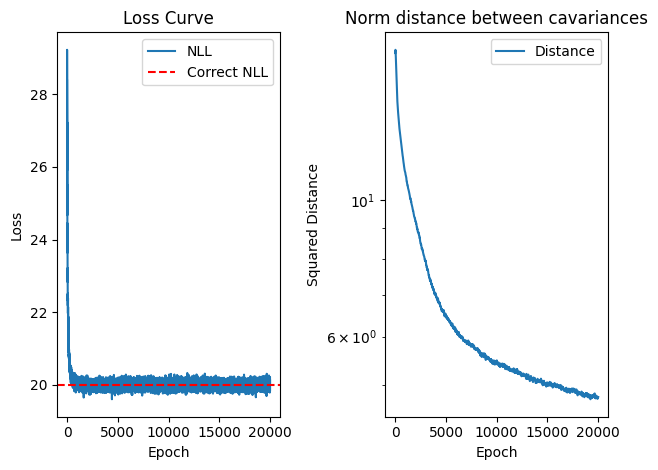

In [217]:
# Plot the lplt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_learned, label='NLL')
#plot NLL of the correct L
plt.axhline(y=loss_correct.item(), color='r', linestyle='--', label='Correct NLL')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot the squared distance between right and fitted sigma
plt.subplot(1, 2, 2)
plt.plot(distances, label='Distance')
plt.xlabel('Epoch')
plt.ylabel('Squared Distance')
plt.title('Norm distance between cavariances')
plt.legend()
plt.yscale('log')

plt.tight_layout()
plt.show()

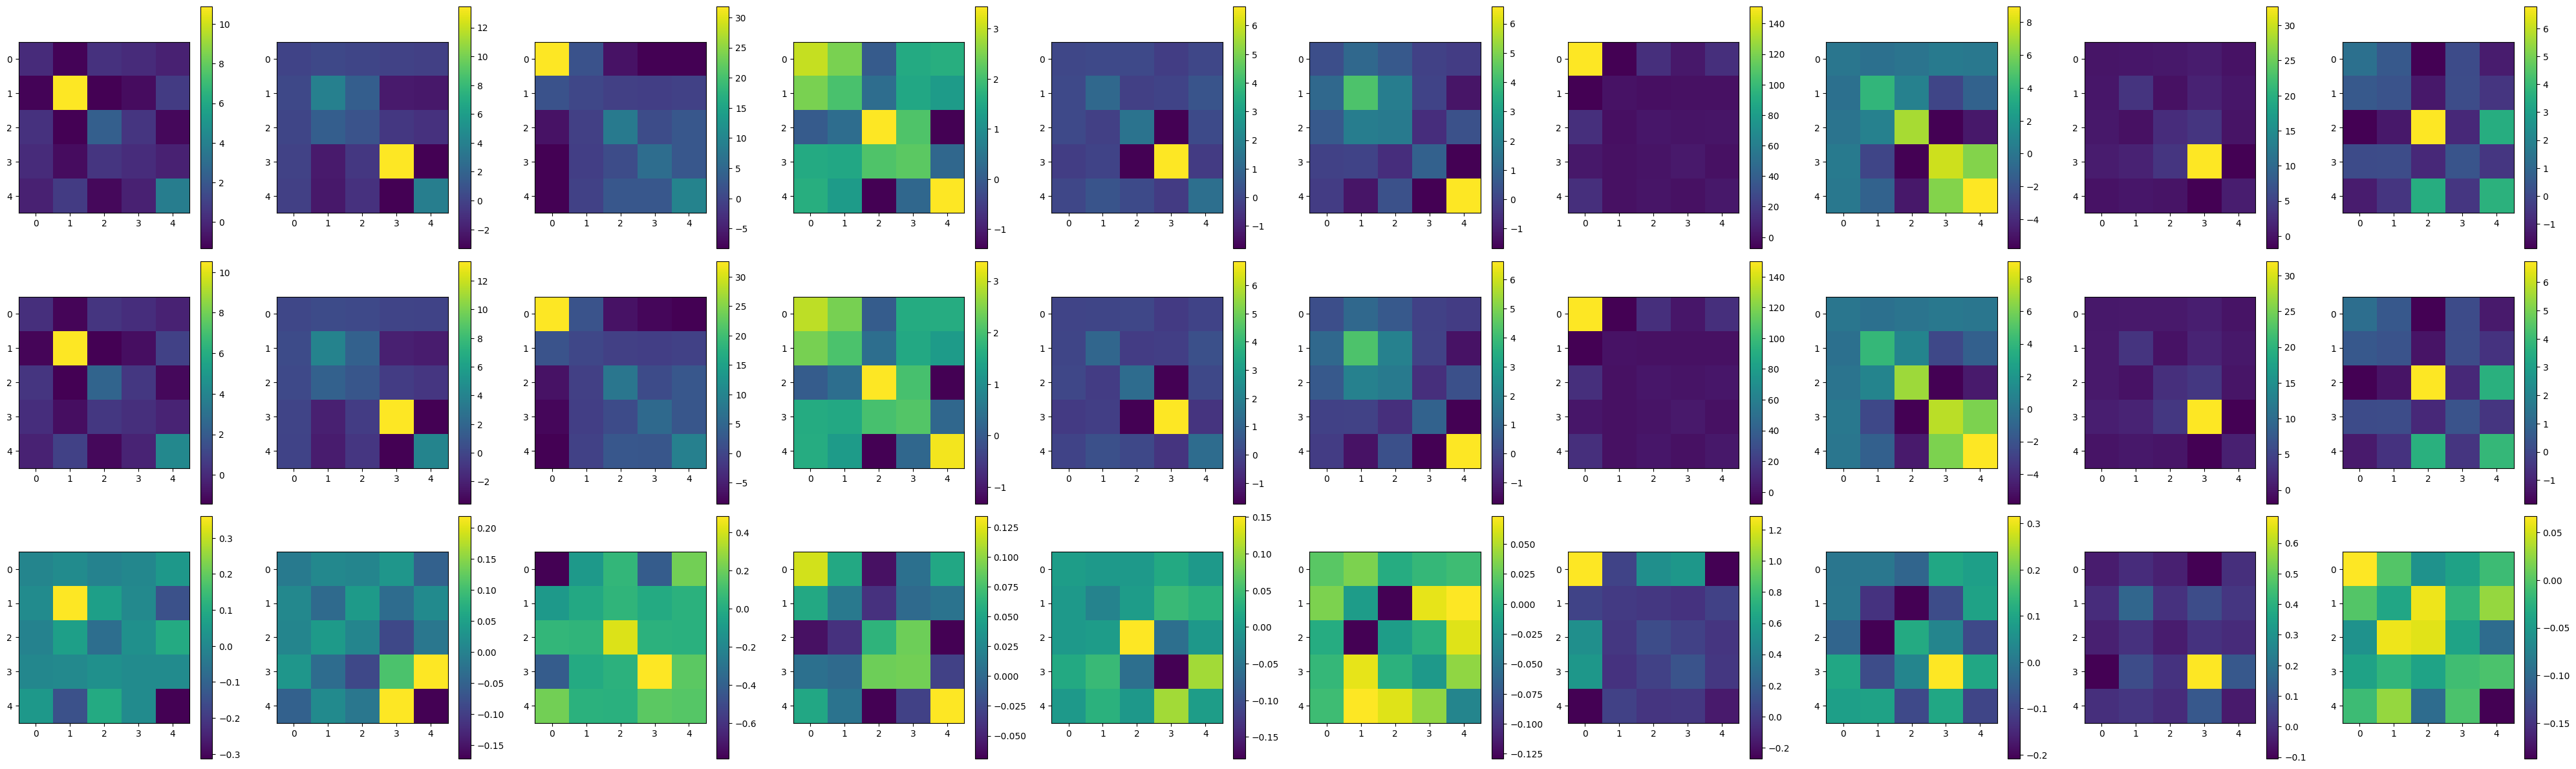

In [216]:
A_learned = cholesky_parametrization(L_learned)
A_correct = cholesky_parametrization(right_L)
fig, axs = plt.subplots(3, A_learned.shape[0], figsize=(4*A_learned.shape[0], 12))
n_matrices = A_learned.shape[0]
if n_matrices == 1:
    axs = axs[:, None]
for i in range(A_learned.shape[0]):
    im0 = axs[0, i].imshow(A_learned[i].detach().numpy())
    fig.colorbar(im0, ax=axs[0, i])
    
    im1 = axs[1, i].imshow(A_correct[i].detach().numpy())
    fig.colorbar(im1, ax=axs[1, i])
    
    im2 = axs[2, i].imshow((A_learned[i] - A_correct[i]).detach().numpy())
    fig.colorbar(im2, ax=axs[2, i])

plt.tight_layout()
plt.show()